# Comparing a USGSCSM and ISIS camera for Cassini ISS

In [1]:
import os 
import sys
os.environ["ISISROOT"] = "/anaconda3/envs/test"

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json
import pvl

import ale
from ale import util
from ale.drivers.co_drivers import CassiniIssPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm
from ale.drivers import AleJsonEncoder

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Fetch the test image

In [3]:
imageLink = 'https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2071/data/1702247425_1702389962/N1702360370_1.IMG'
lblLink = os.path.splitext(imageLink)[0] + '.LBL'
!wget -N -P data/ {imageLink}
!wget -N -P data/ {lblLink}
fileName = 'data/' + os.path.split(lblLink)[1]

--2019-10-28 16:14:54--  https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2071/data/1702247425_1702389962/N1702360370_1.IMG
Resolving pds-imaging.jpl.nasa.gov... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File 'data/N1702360370_1.IMG' not modified on server. Omitting download.

--2019-10-28 16:14:55--  https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2071/data/1702247425_1702389962/N1702360370_1.LBL
Resolving pds-imaging.jpl.nasa.gov... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File 'data/N1702360370_1.LBL' not modified on server. Omitting download.



## Ingest the image, spiceinit, and create a usgscsm sensor model

In [4]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.ciss2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)
    
kernels = util.get_kernels_from_isis_pvl(pvl.load(cub_loc)["IsisCube"], format_as="list")

# Isis doesn't ship IK kernels
cassini_ik_kernel = os.path.join(ale.spice_root, "co-s_j_e_v-spice-6-v1.0", "cosp_1000", "data", "ik", "cas_iss_v10.ti")
kernels.insert(0, cassini_ik_kernel)    

['/usgs/cpkgs/isis3/data/base/kernels/spk/de430.bsp', '/usgs/cpkgs/isis3/data/base/kernels/spk/sat425.bsp', '/usgs/cpkgs/isis3/data/cassini/kernels/spk/180628RU_SCPSE_11337_11357.bsp', '/usgs/cpkgs/isis3/data/cassini/kernels/ck/11344_11349ra.bc', '/usgs/cpkgs/isis3/data/cassini/kernels/fk/cas_v40.tf', '/usgs/cpkgs/isis3/data/base/kernels/pck/pck00009.tpc', '/usgs/cpkgs/isis3/data/cassini/kernels/pck/cpck15Dec2017.tpc', '/usgs/cpkgs/isis3/data/cassini/kernels/iak/IssNAAddendum004.ti', '/usgs/cpkgs/isis3/data/base/kernels/lsk/naif0012.tls', '/usgs/cpkgs/isis3/data/cassini/kernels/sclk/cas00172.tsc']


In [5]:
with CassiniIssPds3LabelNaifSpiceDriver(fileName, props={"kernels":kernels}) as driver:
    usgscsm_dict = to_usgscsm(driver)
    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'), cls=AleJsonEncoder)
camera = knoten.csm.create_csm(fileName)

setting from list
In Formatter
Starting Rotations


In [6]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

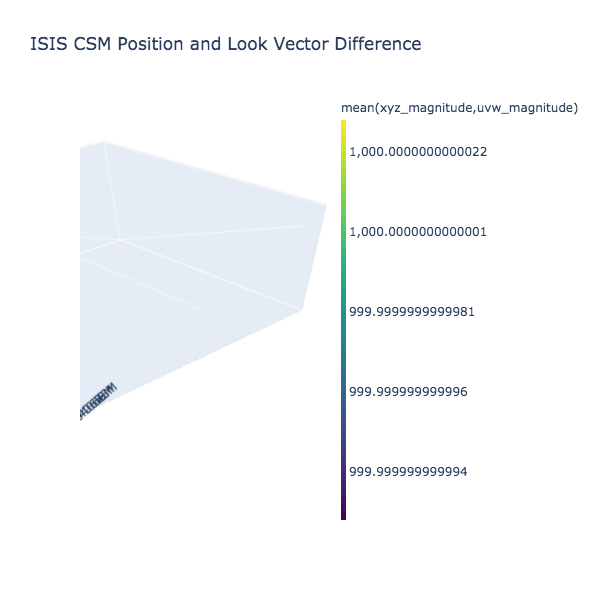

In [7]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

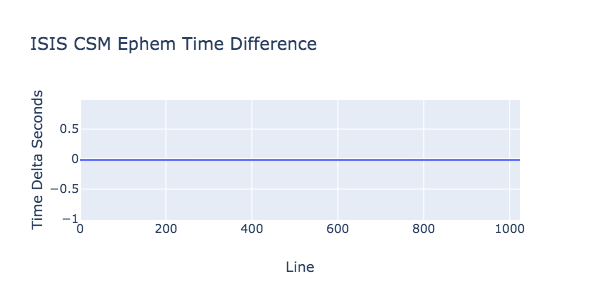

In [8]:
Image(csmisis_diff_ephem_plot_bytes)

In [9]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.0000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,107.6585,45.916126,-0.341279,-97.016359,-993.990617,-23.774910
std,0.0000,0.000000,0.000000,1.757573,0.176735,1.768866
min,107.6585,45.916126,-0.341279,-100.883539,-994.392499,-27.752358
25%,107.6585,45.916126,-0.341279,-98.340241,-994.117828,-25.104648
50%,107.6585,45.916126,-0.341279,-97.016552,-993.989110,-23.775064
75%,107.6585,45.916126,-0.341279,-95.692394,-993.864937,-22.445135
max,107.6585,45.916126,-0.341279,-93.148556,-993.578323,-19.796640


In [10]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 10, 500, 500)

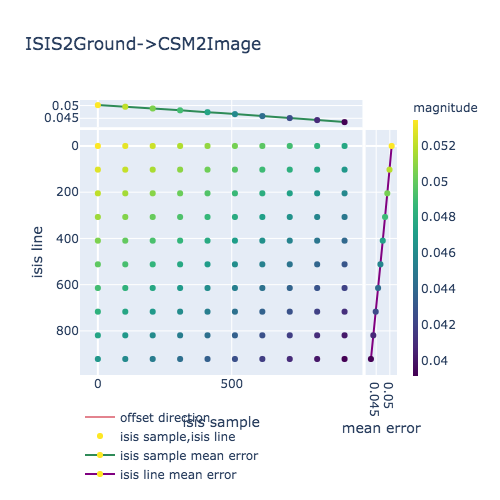

In [11]:
Image(isis2csm_plot.to_image())

In [12]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,0.040227,-0.023865
std,0.003381,0.003926
min,0.033803,-0.031361
25%,0.037390,-0.027018
50%,0.040331,-0.023995
75%,0.043044,-0.020850
max,0.046144,-0.015513


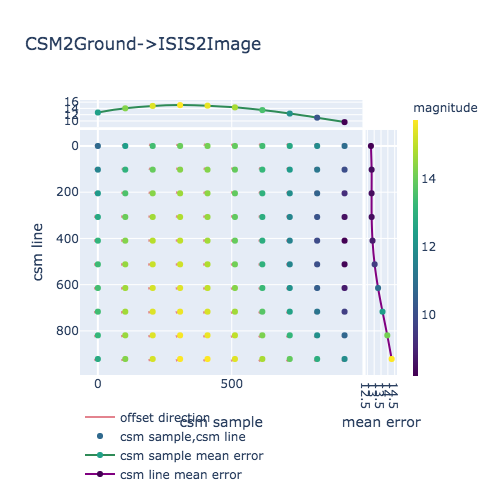

In [13]:
Image(csm2isis_plot.to_image())

In [14]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,0.148203,-12.404065
std,4.466805,2.182078
min,-8.100633,-15.225112
25%,-3.531808,-14.123453
50%,-0.010577,-12.907211
75%,3.829892,-11.213181
max,8.825093,-7.305155


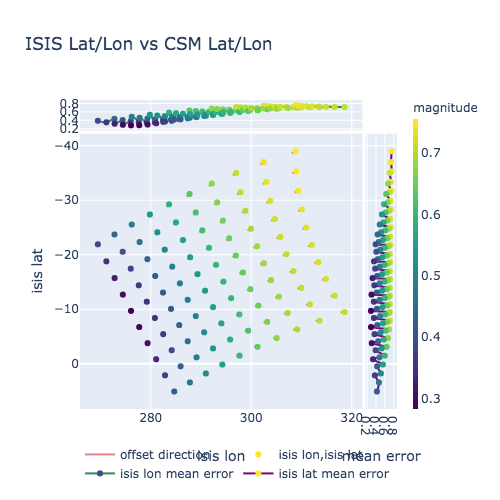

In [15]:
Image(isiscsm_plotlatlon.to_image())

In [18]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,100.000000,100.000000,100.000000
mean,0.022951,4594.036308,106.103169
std,0.001867,453.369079,17.638133
min,0.018746,3334.282436,62.512247
25%,0.021616,4277.994334,92.799698
50%,0.022951,4694.219764,106.513479
75%,0.024314,4972.801061,119.393772
max,0.026933,5198.119552,138.884061
